# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to visualize other outcomes when using Optimize Evaluator


In [67]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Stuff for testing


In [68]:
from AMG_function import AMG_model
import numpy as np

outcomes = AMG_model(chapala_flow= 4.9, calderon_flow= 0.6, zapotillo_flow= 0.4, pozos_flow= 1.6, toluquilla_flow= 0.6, 
                aqp1_PP2_to_PP3=-0.2, aqp2_PP3_to_Pozos=-0.2, aqp3_Pozos_to_Toluquilla=-0.3, aqp4_Toluquilla_to_PP1=-0.2)



print(outcomes)




{'supplied_PP1': 1.9813492400000003, 'supplied_PP2': 0.6927895000000001, 'supplied_PP3': 0.8125, 'supplied_Toluquilla': 0.60641126, 'supplied_Pozos': 0.8762000000000001, 'demand_PP1': 2.3243613495370368, 'demand_PP2': 0.6545987164351852, 'demand_PP3': 0.767238162037037, 'demand_Toluquilla': 0.6724239895833333, 'demand_Pozos': 1.0416148269675924, 'delivered_PP1': 3.9690000000000007, 'delivered_PP2': 0.931, 'delivered_PP3': 1.0, 'delivered_Toluquilla': 0.6, 'delivered_Pozos': 1.6, 'supplied_demand_PP1': 0.8524, 'supplied_demand_PP2': 1.0583, 'supplied_demand_PP3': 1.059, 'supplied_demand_Toluquilla': 0.9018, 'supplied_demand_Pozos': 0.8412, 'deficit_sq_PP1': 0.1177, 'deficit_sq_PP2': 0.0015, 'deficit_sq_PP3': 0.002, 'deficit_sq_Toluquilla': 0.0044, 'deficit_sq_Pozos': 0.0274, 'min_supplied_demand': 0.8412, 'min_deficit_sq': 0.0015}


# 1. Tests for a single drought scenario and no uncertainty

In [69]:

drougth_multiplier_1 = 0.7
scenario1= Scenario("drought1", 
                    chapala_flow = 6.9*drougth_multiplier_1, 
                    calderon_flow = 1*drougth_multiplier_1, 
                    zapotillo_flow = 1*drougth_multiplier_1, 
                    pozos_flow = 2.3*drougth_multiplier_1, 
                    toluquilla_flow = 0.5*drougth_multiplier_1)

## 1.1 Formulation 1 with only disagregated supplied demand outcomes

In [70]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)


AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.MAXIMIZE)]

#Specify unceertainties although we don't use them yet just for testing

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]


In [71]:
from ema_workbench import Policy, perform_experiments


n_scenarios = 1
n_policies = 5
seed=23021995




experiments,results = perform_experiments(AMG_model, policies=n_policies, scenarios=1)

[MainProcess/INFO] performing 1 scenarios * 5 policies * 1 model(s) = 5 experiments
100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 366.55it/s]
[MainProcess/INFO] experiments finished


In [72]:

ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

constraints = [Constraint("min_suplied_demand_PP1", outcome_names="supplied_demand_PP1", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP2", outcome_names="supplied_demand_PP2", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP3", outcome_names="supplied_demand_PP3", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Toluquilla", outcome_names="supplied_demand_Toluquilla", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Pozos", outcome_names="supplied_demand_Pozos", function=lambda x: max(0, -x))]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=250, searchover="levers", epsilons=[0.5] * 5, constraints=constraints, reference=scenario1
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
291it [00:03, 86.89it/s]                                                       
[MainProcess/INFO] optimization completed, found 33 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos
0,-0.217399,-0.174176,-0.254565,0.414147,1.0112,1.0633,1.3392,0.1214,0.8338
1,0.743958,-0.310851,-0.877601,-0.167117,0.8486,0.1087,2.2695,0.0810,1.1373
2,-0.600622,0.933220,0.509013,-0.883641,0.6483,1.4439,0.0764,2.1140,1.0484
3,-0.036747,0.105171,0.335869,-0.535299,0.7457,0.8840,1.2556,1.6099,0.6397
4,-0.888368,-0.590822,-0.287294,-0.711978,0.6963,1.7296,1.1238,1.1783,0.5942
5,-0.683577,-0.372393,0.577673,-0.267565,0.8206,1.5262,1.1122,1.5849,0.1908
6,0.288792,-0.113478,-0.934936,-0.469659,0.7640,0.5607,1.7166,0.3181,1.2963
7,-0.878945,-0.145620,0.248832,0.704720,1.0925,1.7202,0.7546,0.3271,0.5375
8,0.488285,-0.851143,0.220808,0.387195,1.0037,0.3626,2.5106,0.6070,0.1147
9,0.142415,0.444959,-0.122084,-0.714250,0.6956,0.7061,1.1195,1.3402,1.1375


C:\Users\ariel\AppData\Local\Temp\ipykernel_15356\2334650345.py:10: UserWarning: 
The markers list has fewer values (1) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=average_demand_per_policy.T, dashes=False, markers="o", palette="viridis")


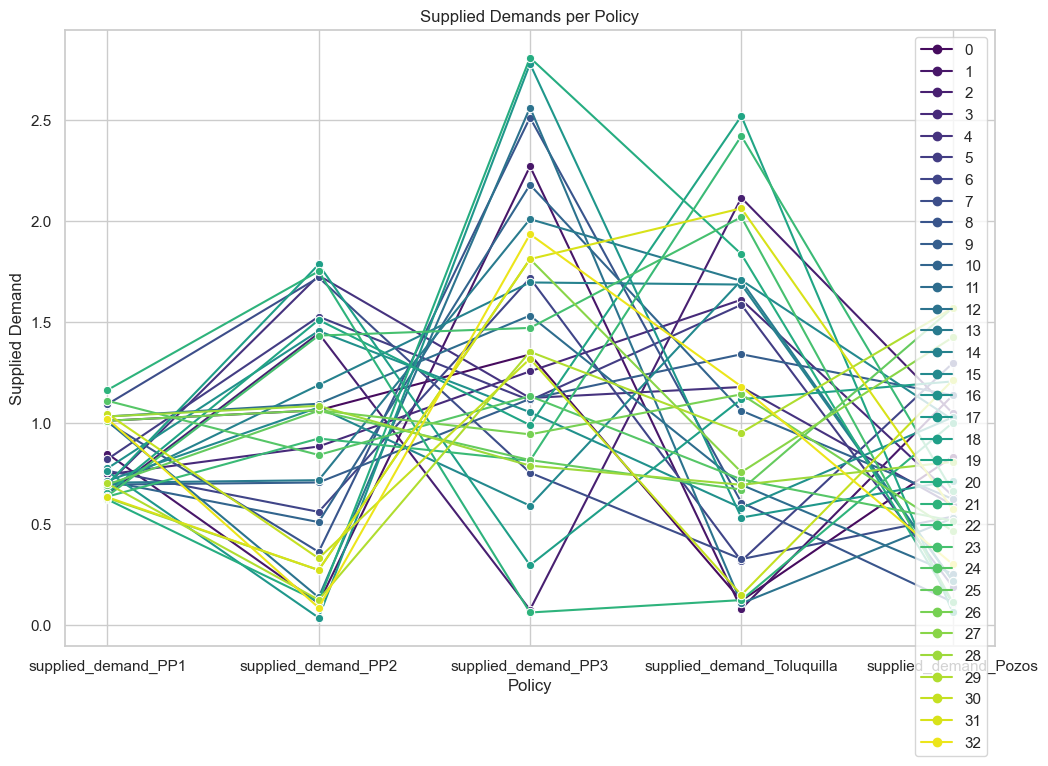

In [73]:


deficit_vars = ["deficit_sq_PP1","deficit_sq_PP2","deficit_sq_PP3","deficit_sq_Toluquilla","deficit_sq_Pozos"]
supplied_demand_vars = ["supplied_demand_PP1","supplied_demand_PP2","supplied_demand_PP3","supplied_demand_Toluquilla","supplied_demand_Pozos"]

# Calculate the average of supplied demands per policy
average_demand_per_policy = results[supplied_demand_vars]

# Create a parallel plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=average_demand_per_policy.T, dashes=False, markers="o", palette="viridis")

# Set plot labels and title
plt.xlabel('Policy')
plt.ylabel('Supplied Demand')
plt.title('Supplied Demands per Policy')

# Show the plot
plt.show()

## 1.2 Formulation 2 with squared deficits outcomes

In [74]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)

#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("deficit_sq_PP1", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_PP2", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_PP3", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_Toluquilla", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_Pozos", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.INFO),
                      ScalarOutcome("min_supplied_demand", kind=ScalarOutcome.INFO)]

#All uncertainties
'''AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),
                           RealParameter('private_intakes_PP1',445436*lowrange,445436*highrange), RealParameter('private_intakes_PP2',125446*lowrange,125446*highrange), RealParameter('private_intakes_PP3',147032*lowrange,147032*highrange), RealParameter('private_intakes_Toluquilla',128862*lowrange,128862*highrange), RealParameter('private_intakes_Pozos',199613*lowrange,199613*highrange),
                           RealParameter('public_consumption',129*lowrange,129*highrange),
                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),
                           RealParameter('node_division',0.35*lowrange,0.35*highrange),
                           RealParameter('loss_grid',0.3*lowrange,0.3*highrange), RealParameter('loss_potabilisation',0.05*lowrange,0.05*highrange),
                           RealParameter('rainfall',0,80*1.5), RealParameter('harvest_coeficient',0.75*lowrange,0.75*highrange), RealParameter('average_household_area',80*lowrange,80*highrange),
                           ]
        '''

"AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),\n                           RealParameter('private_intakes_PP1',445436*lowrange,445436*highrange), RealParameter('private_intakes_PP2',125446*lowrange,125446*highrange), RealParameter('private_intakes_PP3',147032*lowrange,147032*highrange), RealParameter('private_intakes_Toluquilla',128862*lowrange,128862*highrange), RealParameter('private_intakes_Pozos',199613*lowrange,199613*highrange),\n                           RealParameter('public_consumption',129*lowrange,129*highrange),\n                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),\n                           RealParameter('node_division',0.35*lowrange,0.35*highrange),\n                           RealParameter('l

In [75]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging, Constraint, Scenario

ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

constraints = [Constraint("min_suplied_demand_PP1", outcome_names="supplied_demand_PP1", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP2", outcome_names="supplied_demand_PP2", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP3", outcome_names="supplied_demand_PP3", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Toluquilla", outcome_names="supplied_demand_Toluquilla", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Pozos", outcome_names="supplied_demand_Pozos", function=lambda x: max(0, -x))]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=250, searchover="levers", epsilons=[0.01] * 5, reference=scenario1
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
294it [00:03, 74.31it/s]                                                       
[MainProcess/INFO] optimization completed, found 24 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,deficit_sq_PP1,deficit_sq_PP2,deficit_sq_PP3,deficit_sq_Toluquilla,deficit_sq_Pozos
0,0.018797,-0.004612,0.398292,0.503104,0.0070,0.0126,0.0922,0.0503,0.2374
1,-0.658674,0.730711,0.424288,0.289961,0.0030,0.1078,0.3779,0.0047,0.0007
2,-0.226688,0.230155,-0.669874,-0.776177,0.5590,0.0023,0.0001,0.0076,0.1294
3,-0.791507,0.089784,0.676345,0.286569,0.0032,0.1719,0.0809,0.0095,0.3680
4,0.203927,0.094241,0.543703,0.193155,0.0138,0.0540,0.1294,0.0051,0.2678
5,-0.959252,-0.246996,0.291646,-0.213103,0.1457,0.2742,0.0305,0.0296,0.3312
6,0.022755,0.160118,-0.152529,-0.352242,0.2229,0.0131,0.0396,0.0007,0.0005
7,-0.807422,0.089784,0.226838,0.217794,0.0103,0.1806,0.0869,0.0226,0.0989
8,-0.318538,0.088532,0.717986,0.470360,0.0039,0.0115,0.0006,0.0000,0.4026
9,-0.733776,-0.264110,-0.597872,-0.732456,0.5174,0.1422,0.0003,0.0047,0.0001


In [76]:
df = results[deficit_vars]
df["average_deficit_sq"] = round(df.mean(axis=1),2)

#Filter the policies to the top n with lowest average deficit sq
n=5
df = df.nsmallest(n,["average_deficit_sq"])


df.head()

C:\Users\ariel\AppData\Local\Temp\ipykernel_15356\3511461478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["average_deficit_sq"] = round(df.mean(axis=1),2)


,deficit_sq_PP1,deficit_sq_PP2,deficit_sq_PP3,deficit_sq_Toluquilla,deficit_sq_Pozos,average_deficit_sq
23,0.0075,0.0002,0.0000,0.0629,0.0069,0.02
6,0.2229,0.0131,0.0396,0.0007,0.0005,0.06
14,0.0102,0.0623,0.0761,0.0253,0.1239,0.06
16,0.0193,0.0115,0.0055,0.0410,0.2838,0.07
19,0.0131,0.0623,0.0178,0.0313,0.2400,0.07


C:\Users\ariel\AppData\Local\Temp\ipykernel_15356\3799682144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["average_deficit_sq"] = df.mean(axis=1)


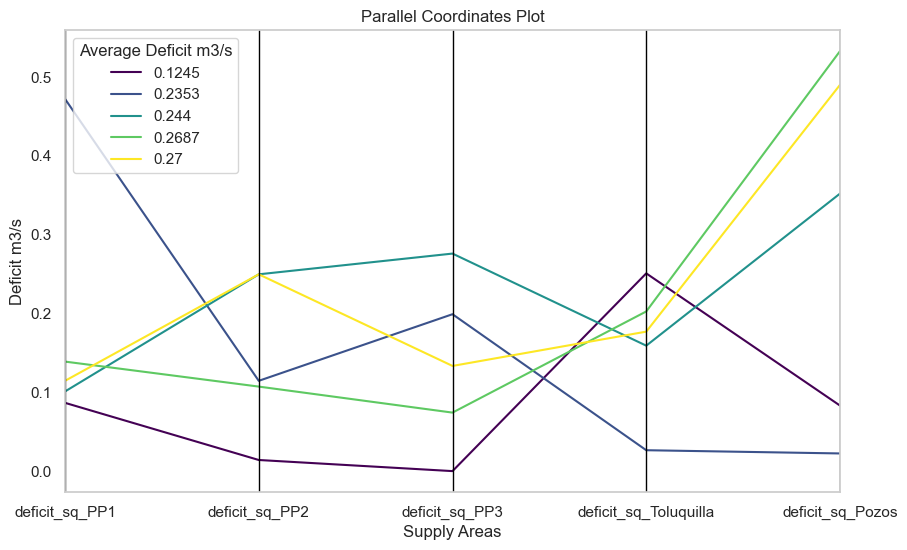

In [77]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

deficit_vars = ["deficit_sq_PP1","deficit_sq_PP2","deficit_sq_PP3","deficit_sq_Toluquilla","deficit_sq_Pozos"]

# Calculate the average of supplied demands per policy
df = results[deficit_vars]
df["average_deficit_sq"] = df.mean(axis=1)

#Filter the policies to the top n with lowest average deficit sq
n=5
df = df.nsmallest(n,["average_deficit_sq"])

#reconvert to fix units
df = round(df**0.5,4)


# Plot parallel coordinates
plt.figure(figsize=(10, 6))
pd.plotting.parallel_coordinates(df, 'average_deficit_sq', colormap='viridis')

# Create and set the legend title
plt.legend(title='Average Deficit m3/s')

# Set plot labels and title
plt.xlabel('Supply Areas')
plt.ylabel('Deficit m3/s')
plt.title('Parallel Coordinates Plot')

# Show the plot
plt.show()

## 2. Single scenario with uncertainty (not implemented)


In [78]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)


AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.MAXIMIZE)]



#All uncertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),
                           RealParameter('private_intakes_PP1',445436*lowrange,445436*highrange), RealParameter('private_intakes_PP2',125446*lowrange,125446*highrange), RealParameter('private_intakes_PP3',147032*lowrange,147032*highrange), RealParameter('private_intakes_Toluquilla',128862*lowrange,128862*highrange), RealParameter('private_intakes_Pozos',199613*lowrange,199613*highrange),
                           RealParameter('public_consumption',129*lowrange,129*highrange),
                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),
                           RealParameter('node_division',0.35*lowrange,0.35*highrange),
                           RealParameter('loss_grid',0.3*lowrange,0.3*highrange), RealParameter('loss_potabilisation',0.05*lowrange,0.05*highrange),
                           RealParameter('rainfall',0,80*1.5), RealParameter('harvest_coeficient',0.75*lowrange,0.75*highrange), RealParameter('average_household_area',80*lowrange,80*highrange),
                           ]


#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]
        

# 3. Multiple drought scenarios, no uncerainty (not implemented)


In [79]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)


AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.MAXIMIZE)]

#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]